# Lab3.4 Sentiment Analysis with machine-learning

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

The focus of this notebook is on performing sentiment analysis using the scikit-learn package. Material from [this notebook](http://www.pitt.edu/~naraehan/presentation/Movie+Reviews+sentiment+analysis+with+Scikit-Learn.html) was re-used and adapted.
The notebook will give you a recipe to train a classifier to assign interpretation labels (specifically the sentiment expressed) to texts and evaluate their performance. This counts as supervised learning because the labels are assigned by people judging the texts and the machine mimics this behaviour.

**At the end of this notebook, you will be able to**:
* load text data from subdirectories on disk, i.e. airline tweets and movie reviews, with the names of the subdirectories as their interpretation labels
* inspect the data and their distribution over the labels
* represent each text as a Bag-of-Words
* convert Bag-of-Word counts to TF-IDF values
* split the data into a train and test sets
* train a *NaiveBayesClassifier* with the training part
* apply the trained classifier on the test part
* evaluate the result
* apply the classifier to any other set of text data


## Prerequisites

For training a machine learning system we need a number of packages, the most important ones are *sklearn* and *numpy* to manipulate data and call machine learning functions. Since we are dealing with texts, we also need some specific packages from *sklearn* to operate on texts to get words as features. Finally, we use the *nltk* package to get a list of *stop words*. *Stop words* occur frequently in any text and are not discriminative across texts. We assume you have all these packages already installed using **pip** or **conda** in the previous notebooks so you can import them here.

In [5]:
import sklearn
import numpy
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## Loading a dataset
We are first going to load and inspect the **airlinetweets** dataset (which is included in the data folder that you downloaded from the HLT course Github). This data set originates from:

https://www.kaggle.com/crowdflower/twitter-airline-sentiment

Kaggle is a platform where you can find many more data sets.

We are going to use the imported method **load_files** which is part of sklearn. Let's first inspect what the help message of the function **load_files** states.

In [2]:
help(load_files)

Help on function load_files in module sklearn.datasets._base:

load_files(container_path, *, description=None, categories=None, load_content=True, shuffle=True, encoding=None, decode_error='strict', random_state=0, allowed_extensions=None)
    Load text files with categories as subfolder names.
    
    Individual samples are assumed to be files stored a two levels folder
    structure such as the following:
    
        container_folder/
            category_1_folder/
                file_1.txt
                file_2.txt
                ...
                file_42.txt
            category_2_folder/
                file_43.txt
                file_44.txt
                ...
    
    The folder names are used as supervised signal label names. The individual
    file names are not important.
    
    This function does not try to extract features into a numpy array or scipy
    sparse matrix. In addition, if load_content is false it does not try to
    load the files in memory.
    
    

There are many options and parameters but here we focus on the structure of the data on disk to use it.
It assume you have the following general structure of data:

* container_folder/
    * category_1_folder/ (e.g., 'positive')
        * file_1.txt
        * file_2.txt
        * ...
        * file_42.txt
    * category_2_folder/ (e.g., 'negative')
        * file_43.txt
        * file_44.txt
        * ...
        
The names of the subfolders are treated as the labels for the data and you are supposed to divided the text files over the subfolders accordingly. These names could be sentiment labels but also topics, genres, style or any other label that is associated with the collection of texts in each subfolder.

The texts should be in plain text format (extension .txt) so it will not work for PDF, Word or HTML files.

Let's check whether our **airlinetweets** corpus has this structure. In the data folder, you will see a folder "airlinetweets" with 3 subfolders: "negative", "neutral", and "positive". These subfolder names will represent our sentiment labels. In each folder, you find a long list of text files, each containing a tweet. This is our data per sentiment category.

We will use the **pathlib** package to get the path of this notebook with the function ```cwd``` (**c**urrent **w**orking **d**irectory) and extend it with "data/airlinetweets" with the function ```joinpath```, assuming that you stored the data in this location. If this is not the case, you need to adapt the path accordingly.

In [7]:
import pathlib
current_working_directory = pathlib.Path.cwd()
airline_tweets_folder = current_working_directory.joinpath('data/airlinetweets')
print('path:', airline_tweets_folder)
print('this will print True if the folder exists:', 
      airline_tweets_folder.exists())

path: /Users/piek/Desktop/t-MA-HLT-introduction-2023/ma-hlt-labs/lab3.machine_learning/data/airlinetweets
this will print True if the folder exists: True


In [8]:
str(airline_tweets_folder)

'/Users/piek/Desktop/t-MA-HLT-introduction-2023/ma-hlt-labs/lab3.machine_learning/data/airlinetweets'

Inspect on your local machine whether the data has the required structure. Take your time to open files and inspect them. It is always good to know what forms your data.

....

....

Hopefully, it is! Let's now load it using the **load_files** function.

In [13]:
# loading all files as data.
airline_tweets_data = load_files(str(airline_tweets_folder))

Note!! If you get an error about not being able to load files with the name ```/.ipynb_checkpoints``` this means you opened the folder from the notebook and Jupyter created a hidden directory to trace this. You can remove these files using the following command for the full path to the directory. E.g.:

In [14]:
!rm -r '/Users/piek/Desktop/t-MA-HLT-introduction-2023/ma-hlt-labs/lab3.machine_learning/data/airlinetweets/negative/.ipynb_checkpoints'

rm: /Users/piek/Desktop/t-MA-HLT-introduction-2023/ma-hlt-labs/lab3.machine_learning/data/airlinetweets/negative/.ipynb_checkpoints: No such file or directory


Alternatively, you can download the data from Github again and replace the date folder altogether manually.

## Inspecting the dataset

The load_files function will read each file separately and store it as a data item. The data is internally stored as a specfic type of object called *Bunch*, which consists of:

* `DESCR`: a description of the data 
* `filenames`: a list with the content of the loaded files, 
* `data`: a list with all the texts loaded from the files,
* `target`: a list with the numeric representations of the corresponding labels, and
* `target_names`: a list with the names of the category in the order of their numerical representation


In [15]:
print(type(airline_tweets_data))
print(dir(airline_tweets_data))
print(type(airline_tweets_data.target))
print('Target names', airline_tweets_data.target_names)

<class 'sklearn.utils._bunch.Bunch'>
['DESCR', 'data', 'filenames', 'target', 'target_names']
<class 'numpy.ndarray'>
Target names ['negative', 'neutral', 'positive']


How many files do we have? Well, that should be the same as the number of text items in `data` and labels in `target`.

In [16]:
print('Number of filenames loaded', len(airline_tweets_data.filenames))
print('Number of text data items created from the loaded files', len(airline_tweets_data.data))
print('Number of text data labels created from the loaded files', len(airline_tweets_data.target.tolist())) 

Number of filenames loaded 4755
Number of text data items created from the loaded files 4755
Number of text data labels created from the loaded files 4755


In [17]:
#Print the first ten items in the list of data
print(airline_tweets_data.data[:10])

[b'@AmericanAir Why is your cover photo of TWA? Just wondering.', b'@united next day', b'"@JetBlue Thank you that it is not just a livery; it is a culture that 16', b'@SouthwestAir I cannot DM you as you do not follow me.', b'"@VirginAmerica Funny story', b'@united flight 403 is delayed 40 min bc a missing screw and were in danger of missing flight 6491', b'@AmericanAir does it show that we are on the same plane?', b"@united @perfectomobile You really shouldn't use the word 'crashing.' Just sayin'.", b"@united what's a good number to call to speak with someone about how you can fix what you did to 50 people and their luggage on Saturday?", b'@USAirways Im researching a flight &amp; noticed a small issue w/class of service between your site &amp; other sites. Could Reservations help me?']


We see here the first ten tweets that were loaded. So what are the associated labels?

Note that *target* is a **numpy.ndarray** which stands for numeric data array. To print them, we need to convert the **ndarray** to a list.

In [18]:
#Print the first ten items in the list
print(airline_tweets_data.target.tolist()[:10])

[1, 1, 2, 1, 0, 0, 1, 1, 0, 1]


We see a sequence of 0, 1, 2 values which are the first nine labels for each of the first nine texts. To decode the numbers, you need to check the list of ```target_names```. A ```0``` corresponds to the first element in that list (negative), a ```1``` with the second (neutral) and a ```2``` to the third (positive). The first nine labels printed can thus be decoded to:

```[neutral, neutral, positive, negative, negative, neutral, neutral, negative, neutral]```

Let's is look at the actual text instances. What is the first text, which is supposed to be neutral:

In [19]:
# Let's inspect the first data element
airline_tweets_data.data[0]

b'@AmericanAir Why is your cover photo of TWA? Just wondering.'

In [20]:
# which comes from the first file which is loaded from the "neutral" folder
airline_tweets_data.filenames[0]

'/Users/piek/Desktop/t-MA-HLT-introduction-2023/ma-hlt-labs/lab3.machine_learning/data/airlinetweets/neutral/AL_570069345818161152.txt'

In [21]:
# first file is a neutral review and is mapped to index 1 in target_names
airline_tweets_data.target[0]

1

We can find out what the index means by inserting it into **target_names**

In [13]:
airline_tweets_data.target_names[1]

'neutral'

How many do we have for each category? We can use the **Counter** package in Python to get statistics from the target structure by counting each category value and displaying the category using the index. The **Counter** function takes as input a list, so we give it the sequence of labels and let it count.

**Counter** returns a list of pairs with the counted item and its frequency. We create a for loop over this list and for each item, we get the item and the count. Next, we print the item, which is the numeric representation of the category, the name of the category that we get from `target_names`, and the frequency count.

In [23]:
from collections import Counter

freqs = Counter(airline_tweets_data.target)
print(type(freqs))

## a Counter object consists of items which are pairs with an element and its count
for item, frequency in freqs.items():
    print(item, airline_tweets_data.target_names[item], frequency)

<class 'collections.Counter'>
1 neutral 1515
2 positive 1490
0 negative 1750


We can see that the data are more or less equally distributed over the three categories, which is good!

Think about how the data was structured in terms of subfolders that represent the label names and a collection of texts distributed over the corresponding folders. You could create such a data set yourself easily. Subfolders could be emotion labels, text topics, or any other label that you want to associate with a text. You just need to find sufficient examples to train and test a classifier.

Next, we will represent the text such that a machine learning system can handle them and associate with interpretation labels.
To do so, we create a **numeric** representation of the text that is called a **Bag-of-Words**. In this representation, the order of the words does not matter, but just the words that occur in it. This representation looses information but generalises well to other unseen texts.

## Extracting a Bag-of-Words text representations from the data

We now loaded a data set as instances of the object <class 'sklearn.utils.Bunch'>. Next, we are going to use the **CountVectorizer** function to process the text data and to create a **Bag-of-Words** presentation as we have done before for the toy data. We define an instance of CountVectorizer for the data set and set a number of parameters that design the model:

* `min_df`: a frequency threshold below which words are ignored to represent a document
* `max_df`: a frequency threshold above which words are ignored to represent a document
* `tokenizer`: a tokenizer that determines what the words are in a text (a.o. separating punctuation from words)
* `stop_words`: an explicit list of words to be excluded from the representation

Note that these parameter settings can be changed, which changes the model. Increasing the `min_df` threshold and lowering the `max_df` threshold mean less words to represent a document. In general, words that only occur once poorly generalise to other data and words that always occur in all texts poorly discriminate between different categories. Furthermore, stop word lists are often derived from large text collections taking the most frequent words, which may boil down to set a `max_df` threshold. However, this is not always the case and you could add specific words yourself to remove noisy or disturbing words from the model.

As a language technology engineer, you need to think about these parameter settings in relation to properties of the texts and the interpretation labels. These are considerations that may be relevant:

* Which words are excluded by setting thresholds or using stopwords and how relevant are these for the interpretation labels?
* Which words occur a lot and do not convey information for my labels?

By experimenting with the parameters, you may tune a model to your texts and your interpretations. For example, words such as "not", "should", "will", "want", etc. may be very frequent in certain text and not others. They may be important for sentiment and emotion detection but not for determining the topic of a text.

In the current notebook, we set a minimal threshold `min_df=10`. We also use **nltk** to tokenize the text and provide a stop word list:

In [24]:
# initialize airline_vec object, and then turn airline tweets train data into a vector 

airline_vec = CountVectorizer(min_df=10, # If a token appears fewer times than this, across all documents, it will be ignored
                             tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             stop_words=stopwords.words('english')) # stopwords are removed

We now created a specific instance `airline_vec` of the **CountVectorizer** with the parameter settings. You could create other instances with different settings. We can use **airline_vec** to generate a vector representation from our texts and count how often which words ocurred in each text. 

**To recap:**
The vector representation reserves position in the list for each word in the complete text data set that matches the parameter conditions. If there are only 5 words, it is a vector of five positions. When initialised it contains five zeros: `[0,0,0,0,0]`. Each document is then represented by counting how frequent each of these words occurs in the text, replacing the zeros by the counts if these words are present.

In order to represent each document in terms of such a vector derived from the complete data set, we use the *fit_transform* function to generate a matrix of documents (rows) and  vectors for each document to represent the words that fit the parameter settings. The function next counts how frequently each word occurs in each document and updates the corresponding positions in each vector (row). This creates the **Bag-of-Words** (BoW) representation of the document.

Note: you might get a warning when you run the following cell. You do NOT have to resolve the warning. It is just a suggestion to extend the stop words list.

In [25]:
airline_counts = airline_vec.fit_transform(airline_tweets_data.data)

/Users/piek/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/piek/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


We have now created a vector representation *airline_counts* based on the parameters settings defined for the instance **airline_vec** being applied to the vocabulary of the full data set. Every position in this vector represents a unique word from the dataset that matched the parameter settings. The words make of the `dimensions` of the model. Here the dimensions are all words but also other features could represented in the vector. This will be explained in the Machine Learning course.

In [26]:
#Total number of word features or the length of the total vector
print('Total number of words in our vectors, which represent dimensions in the model:', len(airline_vec.vocabulary_))

Total number of words in our vectors, which represent dimensions in the model: 653


In [27]:
# First 50 feature names
print(list(airline_vec.get_feature_names_out())[:50])

['!', '#', '$', '&', "'", "''", "'d", "'ll", "'m", "'re", "'s", "'ve", '(', ')', '-', '--', '.', '..', '...', '....', '1', '10', '100', '15', '1k', '1st', '2', '20', '200', '2015', '24', '25', '2nd', '3', '30', '4', '40', '45', '5', '50', '6', '7', '8', ':', ';', '?', '@', '``', 'aa', 'able']


In [28]:
# 'plane' is found in the corpus, mapped to index 1948
airline_vec.vocabulary_.get('plane')

443

Try to change the parameter settings and run the cells again to see what happens to the vocabulary of airline_vec.

So **airline_counts** represents the data according to the model of **airline_vec**.
We can now inspect its dimensions of as a feature array by getting the spape: the rows (documents) and columns (the word vector length).

In [29]:
# large dimensions! 4,755 documents, 2902 unique terms. 
airline_counts.shape

(4755, 653)

It is important to inspect the dimensions of the data matrix. We see that we have 4,755 text instances with each a vector array of 653 positions. Each position represents a word from the training data for which we can set a value that indicates if or how often it occurs in a text instance.

We can convert the matrix to an array and get the 30th element `datarow=30` and look at the vector values for slots `[10:100]` out of the 653 dimensions in total:

In [30]:
datarow = 30
print(airline_counts.toarray()[datarow][10:100])

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can see that most values are zero's and few have the value 1. This is what we call a *sparse vector*. If you change the parameter settings when creating **airline_vec** to use more words, the vector becomes larger and more words of a text are represented. The question is whether these words are also useful, e.g. sufficiently shared across different documents.

As we have seen in the previous Lab, we can also transform the counts into information value scores using the *TfidfTransformer* function.

In [33]:
# Convert raw frequency counts into TF-IDF values
airline_tfidf_transformer = TfidfTransformer()
airline_tfidf = airline_tfidf_transformer.fit_transform(airline_counts)

Obviously the shape remains the same but the values for the previous example are now weighted scores between zero and one.

In [34]:
# Same dimensions, now with tf-idf values instead of raw frequency counts
print(airline_tfidf.shape)
# we print values 10:100 for datarow 
print(airline_tfidf.toarray()[datarow][10:100])

(4755, 653)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33609914
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.26745264
 0.         0.28262499 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0520561  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


## Training and testing a Naive Bayes classifier for airline tweets

We can now use the above data representation as data to train and test a classifier. **Sklearn** provides a large variety of classifiers. We will use here a *NaiveBayes* classifier. To train the classifier, we are first going to split the data into a test and train part. Sklearn has a built in function for this that we need to import.

#### Splitting the data into train and test

In [36]:
# Split data into training and test sets
# from sklearn.cross_validation import train_test_split  # deprecated in 0.18
from sklearn.model_selection import train_test_split

The **train_test_split** function takes as input paramters the full data set as a list of vectors, the labels in the corresponding order and the proportion of the test set out of the total data set. It then returns the proportion of training data, test data, training labels and test labels in this order. We need to catch the output in four variables: ```docs_train```, ```docs_test```, ```human_labels_train```, ```human_labels_test```. We choose 80% training and 20% test and assign the output to four coresponding variables.

In [37]:
docs_train, docs_test, human_labels_train, human_labels_test = train_test_split(
    airline_tfidf, # the tf-idf model derived from all the data 
    airline_tweets_data.target, # the labels for all the data
    test_size = 0.20 # we use 80% for training and 20% for development
    ) 

We now find our training texts in *docs_train* and our test texts in *docs_test*. The corresponding sequence of labels for training are in *human_labels_train*, and those for testing are in *human_labels_test*.

In [38]:
print("Training texts:", len(docs_train.toarray()))
print("Training labels:", len(human_labels_train))
print("Test texts:", len(docs_test.toarray()))
print("Test labels:", len(human_labels_test))

Training texts: 3804
Training labels: 3804
Test texts: 951
Test labels: 951


We see that we have an equal number of texts and labels for train and test. The values should be in the right order.

One training instance looks like this:

In [42]:
docs_train[55].toarray()[0][10:100]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.40935998, 0.        ,
       0.        , 0.13335012, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

it's label is:

In [43]:
human_labels_train[55]

2

which we know is:

In [44]:
airline_tweets_data.target_names[human_labels_train[55]]

'positive'

#### Training a **NaiveBayes** classifier

Now we separated the train and test data we can train a model. We are going to use a simple NaiveBayes classifier to train the model. A NaiveBayes (NB) classifier is a so-called generative classifier that learns the probablity of a word given a category. By assessing the probability of words for a text, it can aggregate how likely a text is for a category. You will learn more about this type of classifier in the machine learning course. For now it is enough to know that NB works reasonably for smaller data sets and with little training. You can check out this tutorial for more information: https://web.stanford.edu/class/cs124/lec/naivebayes.pdf.

Because we have multiple labels (negative, positive, neutral) and therefore are dealing with 3 classes, we need a *multinomial classifier*.

In [46]:
# Now ready to build a classifier. 
# We will use Multinomial NaiveBayes as our model
from sklearn.naive_bayes import MultinomialNB

**Sklearn** classifiers have a generic **fit** function that takes as input the training data and the human-assigned labels.

In [47]:
# Train a Multimoda Naive Bayes classifier
airline_tweets_clf = MultinomialNB().fit(docs_train, human_labels_train)

#### Applying the classifier to the test data to generate predictions

After training the classifier, we can apply it to test data that is represented in the same way. For this we use the *predict* function.

In [48]:
# Predicting the Test set results, find macro recall
system_labels_pred = airline_tweets_clf.predict(docs_test)

We can now print each test tweet and get the corresponding prediction.

In [52]:
test_item = 20
#### we need to get the text from the original text data before we did the split.
#### Remember that the nTH item in an array has an index of n-1 because we start the index with zero.
#### Likewise, we take the length of the training data minus 1, to find the start of the test data.
data_index = len(docs_train.toarray())-1+test_item
print('Tweet number:', data_index)
print('The test tweet:', airline_tweets_data.data[data_index])
print('The test tweet representation, showing dimensions 10:100:', docs_test[test_item-1].toarray()[0][10:100])
print('The gold label:', human_labels_test[test_item-1])
print('The classifier predicted:', system_labels_pred[test_item-1])

Tweet number: 3823
The test tweet: b'"Bruh...real tweet from @JetBlue ""Our fleet\'s on fleek. http://t.co/dqny4aKTg9"""'
one test tweet representation, showing dimensions 10:100: [0.         0.         0.         0.         0.         0.
 0.11672648 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.38902417 0.         0.
 0.06336284 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      

Obviously to evaluate the performance it is a lot easier to use the evaluation metrics built in **sklearn**.

### Measuring the quality of the system output against the human labels

Sklearn provides functions to obtain the **recall**, **precision** and **f-score** for all the test set results. We can simply pass the human labels and the system labels as input and set a parameter how to aggregate the overall score. The ```classification_report``` function gives the complete result:

In [54]:
from sklearn.metrics import classification_report
labels=["negative", "neutral", "positive"]

report = classification_report(human_labels_test, system_labels_pred, digits = 3, target_names = labels)
print(report)

              precision    recall  f1-score   support

    negative      0.824     0.858     0.841       372
     neutral      0.778     0.725     0.750       309
    positive      0.822     0.841     0.832       270

    accuracy                          0.810       951
   macro avg      0.808     0.808     0.808       951
weighted avg      0.809     0.810     0.809       951



Whenever you generate a report such as this, not only consider the overall performance such as **accuracy** or (macro/weighted) average **f1-score** but also the results per category and what the relation is between **recall** and **precision**. Ideally, recall and precision are balanced but if they deviate it is worth thinking about the causes. Furthermore, what works for some cateories does not work for others and categories compete with each other. Some good causes for unbalanced or poor results are:

<ol>
<li>Not enough training data to capture all <b>variation</b> in the test data
<li>Biased training data that makes one category stronger than the other(s)
<li>Too much <b>ambiguity</b> so that words (as features) get different interpretations in different contexts
<li>Over-fitting to the training data so that it learns features that do not generalise to the test data
</ol>

During this master programme, you will work with many different data sets and analyse the performance of classifiers. Analysing different data, experimenting with text representations, settings and machine learning algorithms is the best way to learn about possible causes and how to mitigate them.

Creating a confusion matrix is the first step in understanding the behaviour of a classifier model. For this we use the sklearn.metrics functions *confusion_matrix* and *ConfusionMatricxDisplay*:

In [55]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(human_labels_test, system_labels_pred)
print(matrix)

[[319  33  20]
 [ 56 224  29]
 [ 12  31 227]]


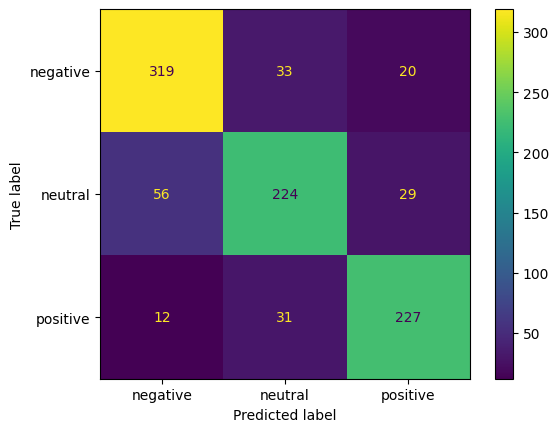

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
display.plot()

We can see here that by far most test cases are classified correctly. There is some spill over to other categories but no significant differences. Most notably is the confusion of "negative" with "neutral" cases (56). This is in line with the precision/recall/f-score results, where "neutral" has lower recall. "Neutral" itself also spills over into "negative" and "positive", reflected by a bit lower precision compared to "negative" and "positive".

The results are reasonable but one of the things you may want to try is to resolve the false positives of the "negative" class so that the recall of "neutral" increases and the precision of "negative". To find out which words cause this, you need to do an error analysis into these false positive test cases: predicted "negative" but the true label was "neutral".

### The train, develop and test paradigm

Note that in practice, results are often more obscure than you see here and you need to work on balancing recall and precision across the different categories. While doing that realise that a scientific approach should **NOT** optimize the model for the test set but on a development set. Once you found the optimal model settings while testing and analysing the development set, you run a single and final evaluation on the test set. The independent test results count and is what you should report in a scientific publication.

## Applying the airline tweets classifier on your own data

Instead of the test set, we can apply our classifier to any other text data as well Let's type a few potential tweets.

In [58]:
# very short and fake movie reviews
my_reviews = ['This movie was excellent', 
               'Absolute joy ride', 
               'Steven Seagal was terrible', 
               'Steven Seagal shined through.', 
               'This was certainly a movie', 
               'Two thumbs up', 
               'I fell asleep halfway through', 
               "We can't wait for the sequel!!", 
               'I cannot recommend this highly enough', 
               'instant classic.', 
               'Steven Seagal was amazing.']
len(my_reviews)

11

To be able to apply our model to these texts, we need to represent the text using the same vector dimensions (columns!) as we used for training the model.

The sklearn transformer function does this work for you using the **transform** function. This function takes the vectors for representing the training data. Note that these vectors have a position for every word in the training data. So we cannot represent words that do not occur outside the training data, so-called Out-of-Vocabulary (OoV) words. Technically, we do not need to worry because the **transform** function will take care of this but you can imagine that texts that are very different from the training data will be represented poorly by the model.

In [59]:
# We re-use airline_vec to transform it in the same way as the training data
my_review_counts = airline_vec.transform(my_reviews)
my_review_counts.shape

(11, 653)

We can see that the shape of our matrix represents 11 rows using the vectors with as many dimensions as words selected from the training data. So words in our 11 movie reviews that are NOT in the training data, are not represented as there are no slots in the vectors from the training data.

We can see this clearly, if we would use the **fit_transform** function instead of **transform** for our tweets, which will create a whole new model from our 11 tweets.

In [31]:
#### NEVER DO THE FOLLOWING ON TEST DATA
##bad_my_review_counts = airline_vec.fit_transform(my_reviews)
##bad_my_review_counts.shape

If you did the above, you will see that there are only 4 dimensions left because the CountVectorizer created complete new vector representations using our settings: min_df=2,tokenizer=nltk.word_tokenize, stop_words=stopwords.words('english'). The vector only represents words from my_reviews and this representation is incompatible with our trained model. So we cannot use this representation!!

This is a mistake you are likely to make. Remember:

1. build a vectore representation from the features from the training data: use **fit** or **fit_transform** with your defined CountVectorizer instance
2. train a classifier from these representation using the **fit** function
3. always, always use the **transform** function from your defined CountVectorizer instance (which has been derived using the training data) to represent any other texts that you want to classify

It is good practice to always use the **shape** function to check that the data has the same number of dimensions as the training data.

Assuming that our own review texts are now propery represented in *my_review_counts*, we can proceed with calculating **TF\*IDF** values and use our trained classifier to make predictions on these representations.

In [61]:
# we compute tf idf values
my_reviews_tfidf = airline_tfidf_transformer.transform(my_review_counts)

In [62]:
my_reviews_tfidf.shape

(11, 653)

These dimensions are correct so let's get the predictions:

In [63]:
# have classifier make a prediction
pred_on_my_reviews = airline_tweets_clf.predict(my_reviews_tfidf)

In [64]:
# print out results ()
for review, predicted_label in zip(my_reviews, pred_on_my_reviews):
    
    print('%s => %s' % (review, 
                        airline_tweets_data.target_names[predicted_label]))

This movie was excellent => positive
Absolute joy ride => negative
Steven Seagal was terrible => negative
Steven Seagal shined through. => negative
This was certainly a movie => negative
Two thumbs up => negative
I fell asleep halfway through => negative
We can't wait for the sequel!! => negative
I cannot recommend this highly enough => negative
instant classic. => negative
Steven Seagal was amazing. => positive


Take a minute to see if these reviews are correctly classified. Obviously, the classifier was trained on iarline tweets and not on tweets reviewing movies. What would be needed to evaluate the performance?

Obviously, you could manually create a list of the correct sentiments for each review and use the above **sklearn** metrics to evaluate the list of predictions with the manually created list. This would give an objective evaluation. In that case, the previes test set could be used as the development set and this independent data could represent the actual use case on which you want to test the classifier.

## Training another classifier with movie reviews

Through the **load_files** function, we can easily load any text collection per category by putting them into separate subfolders. Let's try another one and go through the above procedure once gain but now in a series of quick steps following the fixed recipe.

Remember from the first Lab that some of the NLTK data is structured precisely in the same way as the airlinetweets data, e.g. nltk_data/corpora/movie_reviews.

Likewise, we can load this data in the same way using the load_files function. First adapt the path below to point to the location on your local laptop.

In [65]:
movie_reviews_folder = cwd.joinpath('/Users/piek/nltk_data/corpora/movie_reviews')
print('path:', movie_reviews_folder)
print('this will print True if the folder exists:', movie_reviews_folder.exists())

path: /Users/piek/nltk_data/corpora/movie_reviews
this will print True if the folder exists: True


In [66]:
movie_reviews_data = load_files(str(movie_reviews_folder))
print(type(movie_reviews_data))
print(dir(movie_reviews_data))
print('Number of data items', len(movie_reviews_data.data))
print('Target names', movie_reviews_data.target_names)
print('First data record', movie_reviews_data.data[0])

<class 'sklearn.utils._bunch.Bunch'>
['DESCR', 'data', 'filenames', 'target', 'target_names']
Number of data items 2000
Target names ['neg', 'pos']
First data record b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , th

Given that you loaded your data in the above way, this is the text classification recipe:

## Text classification recipe

We proceed in seven simple steps:

<ol>
    <li>We create a CountVectorizer instance given the parameter settings 
    <li>We use the <b>fit_transform</b> function of the vectorizer to:
        <ol>
            <li>create vector representations for each selected word from the dataset
            <li>represent each text as a vector based on the words counts in the document
        </ol>
    <li>We transfer the count values using <b>TfidfTransformer</b> to information values
    <li>We split the data into train and test with their corresponding labels (maintaining the sequence!)
    <li>We create a <b>MultinomialNB</b> classifier from the training data and their labels
    <li>We apply the classifier on the test data
    <li>We evaluate the test results by comparing the gold labels to the predicted labels
</ol>

You can use the above zeven steps as a **magic recipe** to create any type of text classifier.

#### 1. Create an instance of the CountVectorizer defining the parameter settings

In [67]:
movie_vec = CountVectorizer(min_df=2, # If a token appears fewer times than this, across all documents, it will be ignored
                             tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             stop_words=stopwords.words('english')) # stopwords are removed

#### 2. Model the data according the CountVectorizer instance

Using this instance of CountVectorizer, we can now derive a new (and very different) vector representation from the movie_review data we loaded before. We use here the **fit_transform** function.

In [68]:
movie_counts = movie_vec.fit_transform(movie_reviews_data.data)

/Users/piek/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/piek/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


#### 3. Transform the counts into TD*IDF values

In [69]:
movie_tfidf_transformer = TfidfTransformer()
movie_tfidf = movie_tfidf_transformer.fit_transform(movie_counts)

We can use **shape** to see how many rows and dimensions (columns) our matrix has.

In [70]:
movie_tfidf.shape

(2000, 25139)

So this is a very different vector representation than derived from the airline tweets. Why is that?

#### 4. Split the data and labels into train and test

After representing all the data, we split it into train and test data with their according labels.

In [71]:
movie_docs_train, movie_docs_test, movie_human_labels_train, movie_human_labels_test = train_test_split(
    movie_tfidf, # the tf-idf model based on all the movie reviews
    movie_reviews_data.target, # the movie review labels
    test_size = 0.20 # we use 80% for training and 20% for development
    ) 

In [72]:
print("Training texts:", len(movie_docs_train.toarray()))
print("Training labels:", len(movie_human_labels_train))
print("Test texts:", len(movie_docs_test.toarray()))
print("Test labels:", len(movie_human_labels_test))

Training texts: 1600
Training labels: 1600
Test texts: 400
Test labels: 400


#### 5. Train a classifier with the train data and labels

In [73]:
movie_review_clf = MultinomialNB().fit(movie_docs_train, movie_human_labels_train)

#### 6. Apply the classifier to the test data to get the system predictions

In [74]:
# Predicting the Test set results, find macro recall
system_labels_movie_pred = movie_review_clf.predict(movie_docs_test)

#### 7. Evaluate the predictions on the test data against the gold labels

In [76]:
from sklearn.metrics import classification_report
movie_labels=["negative", "positive"]

report = classification_report(movie_human_labels_test, system_labels_movie_pred, digits = 3, target_names = movie_labels)
print(report)

              precision    recall  f1-score   support

    negative      0.767     0.853     0.808       197
    positive      0.840     0.749     0.792       203

    accuracy                          0.800       400
   macro avg      0.803     0.801     0.800       400
weighted avg      0.804     0.800     0.800       400



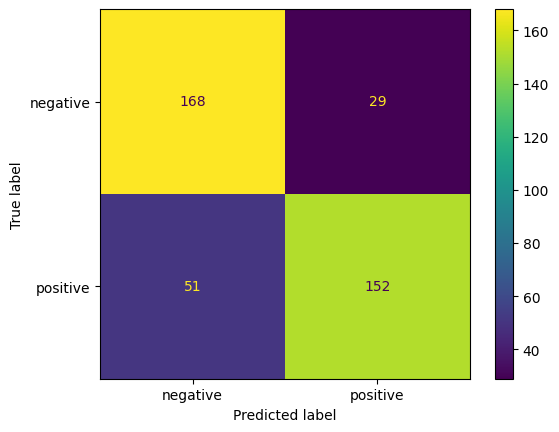

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
movie_matrix = confusion_matrix(movie_human_labels_test, system_labels_movie_pred)
display = ConfusionMatrixDisplay(confusion_matrix=movie_matrix, display_labels=movie_labels)
display.plot()

The confusion matric tells us that  there are 51 false positives with the negative category and 29 false positive for the positive category. This means that the negative category is slightly stronger than the positive category. Again, an error analysis should target these false positives to find out why they get misinterpreted and how to fix this.

## Applying the movie review classifier to your own data

To apply our new classifier to the same my_reviews data, we first need to represent these texts according to the vectors of the movie_review data. So, we call again the **transform** function 

In [79]:
# We re-use airline_vec to transform it in the same way as the training data
my_review_movie_review_counts = movie_vec.transform(my_reviews)
my_review_movie_review_counts.shape

(11, 25139)

In [80]:
reviews_new_tfidf = movie_tfidf_transformer.transform(my_review_movie_review_counts)

In [81]:
movie_review_clf_pred = movie_review_clf.predict(reviews_new_tfidf)

In [82]:
# print out results ()
for review, predicted_label in zip(my_reviews, movie_review_clf_pred):
    
    print('%s => %s' % (review, 
                        movie_reviews_data.target_names[predicted_label]))

This movie was excellent => pos
Absolute joy ride => pos
Steven Seagal was terrible => neg
Steven Seagal shined through. => neg
This was certainly a movie => neg
Two thumbs up => neg
I fell asleep halfway through => neg
We can't wait for the sequel!! => neg
I cannot recommend this highly enough => pos
instant classic. => pos
Steven Seagal was amazing. => neg


Our moview review classifier only uses two categories instead of the airlinetweets classifier. Is it doing any better?

To really evaluate and compare the performances, we need to use a manual list of labels. Note that this classifier only uses two labels and the airline classifier uses three labels. This makes the comparison difficult. It would require to manal evaluation datasets with three and two labels respectively.

## End of this notebook